In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os, sys

sys.path.insert(0,'../')
from src.utils import load_config, split_into_sentences, flatten_list
from src.stats_analysis import compute_pearson_table, compute_anova_table, compute_wilc_table



from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler, RobustScaler

from cca_zoo.linear import SCCA_IPLS

import contextlib
@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

config = load_config('../config.yaml')

[nltk_data] Downloading package punkt to /home/robin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# todo
# compare with and without the density features
# test with all the items
# average the w2v fasttext and glove metrics
# interpret more the wmd distances 
# apply the same analysis to the other datasets: 13 november

In [2]:
data = pd.read_pickle(os.path.join(config['data_isaac']['folder'],config['data_isaac']['features_file']))

all_cosine_sentences_similarity_mean = data.filter(regex = 'all_cosine_sentences_similarity_mean').columns.tolist()
all_cosine_sentences_similarity_std = data.filter(regex = 'all_cosine_sentences_similarity_std').columns.tolist()
all_wmd_sentences_similarity_mean = data.filter(regex = 'all_wmd_sentences_similarity_mean').columns.tolist()
all_wmd_sentences_similarity_std = data.filter(regex = 'all_wmd_sentences_similarity_std').columns.tolist()

consecutive_cosine_sentences_similarity_mean = data.filter(regex = 'consecutive_cosine_sentences_similarity_mean').columns.tolist()
consecutive_cosine_sentences_similarity_std = data.filter(regex = 'consecutive_cosine_sentences_similarity_std').columns.tolist()


Structural_density = [
                        'cluster_density_score_HDBSCAN', 
                        'cluster_reverse_silhouette_score_HDBSCAN',
                        'cluster_density_score_MeanShift', 
                        'cluster_reverse_silhouette_score_MeanShift',
                        'reduction_score_PCA_explained_variance', 
                        'reduction_score_PCA_prop_of_components',]

Semantic_contribution = ['regression_coef_density_score_Lasso',
    'regression_error_score_Lasso',
    'reduction_score_Lasso',
    ]

silhouette_based = ['cluster_reverse_silhouette_score_MeanShift', 'cluster_reverse_silhouette_score_HDBSCAN']
cluster_density_based = ['cluster_density_score_MeanShift', "cluster_density_score_HDBSCAN" ]
pca_based = ['reduction_score_PCA_explained_variance', 'reduction_score_PCA_prop_of_components']
lasso_based = ['regression_coef_density_score_Lasso', 'regression_error_score_Lasso', 'reduction_score_Lasso']

data['all_cosine_sentences_similarity_mean'] = data[all_cosine_sentences_similarity_mean].mean(axis = 1)
data['all_cosine_sentences_similarity_std'] = data[all_cosine_sentences_similarity_std].mean(axis = 1)
data['consecutive_cosine_sentences_similarity_mean'] = data[consecutive_cosine_sentences_similarity_mean].mean(axis = 1)
data['consecutive_cosine_sentences_similarity_std'] = data[consecutive_cosine_sentences_similarity_std].mean(axis = 1)
data['all_wmd_sentences_similarity_mean'] = data[all_wmd_sentences_similarity_mean].mean(axis = 1)
data['all_wmd_sentences_similarity_std'] = data[all_wmd_sentences_similarity_std].mean(axis = 1)

from src.data_cleaning import add_average_data
data = add_average_data(data)

global_topic_structure_features = [
        'cluster_density_score_MeanShift',
        'cluster_reverse_silhouette_score_MeanShift'
    ]

    # Local Topic Structure
local_topic_structure_features = [
        'cluster_density_score_HDBSCAN',
        'cluster_reverse_silhouette_score_HDBSCAN'
    ]

    # Semantic Complexity
semantic_complexity_features = [
        'reduction_score_PCA_explained_variance',
        'regression_error_score_Lasso'
    ]

density = global_topic_structure_features + local_topic_structure_features + semantic_complexity_features + ['narrative_speed_score']
density_average = ["semantic_complexity", "local_topic_structure", "global_topic_structure", "narrative_speed_score"]

#data_item = pd.read_csv(os.path.join(config['data_isaac']['folder'],config['data_isaac']['items_file']))
#data.drop(['Unnamed: 0_x', 'Unnamed: 0_y'], axis=1, inplace=True)

factors = ['NegAff', 'NegFTD', 'Eccentric', 'SocAnx', 'PosFTD'] # "ADHD" , "Constrict", "HypoMania", "VivPercept", "F1", "F2"]
#items = [elt for elt in data_item.columns.tolist() if elt not in ['subj', 'Unamed: 0']]

#items_scaler  = RobustScaler()
#data_item[items] = items_scaler.fit_transform(data_item[items])

#data = data.merge(data_item, on='subj', how='left')

data['cat_enc'] = data['Stim1'].astype('category').cat.codes


#data['random_feature'] = np.random.rand(len(data))
sim_features = data.filter(regex='mean|std').columns.tolist()
std_sim_features = data.filter(regex='std').columns.tolist()

mean_sim_metrics = data.filter(regex = '(sentence_sim)(.*)(mean)').columns.tolist()
std_sim_metrics = data.filter(regex = '(sentence_sim)(.*)(std)').columns.tolist()

density_features = data.filter(regex = "score").columns.tolist()

mean_sim_metrics = data.filter(regex = '(sentence_sim)(.*)(mean)').columns.tolist()
std_sim_metrics = data.filter(regex = '(sentence_sim)(.*)(std)').columns.tolist()

all_mean_words_metrics = data.filter(regex = '(word_sim)(.*)(mean)').columns.tolist()

all_features = density_features + mean_sim_metrics + std_sim_metrics

features_of_interest = ["all_cosine_sentences_similarity_mean",
                        #"all_cosine_sentences_similarity_std",
                        #"all_wmd_sentences_similarity_mean",
                        #"all_wmd_sentences_similarity_std",
                        "consecutive_cosine_sentences_similarity_mean",
                        #"consecutive_cosine_sentences_similarity_std",
                        ] + [
                            "cluster_reverse_silhouette_score_MeanShift",
                            "cluster_density_score_MeanShift",
                            "cluster_reverse_silhouette_score_HDBSCAN",
                            "reduction_score_PCA_explained_variance"
                        ]

features_of_interest = [
    "all_cosine_sentences_similarity_mean",
    "consecutive_cosine_sentences_similarity_mean",
    "all_wmd_sentences_similarity_mean",
    "silhouette_based",
    "cluster_density_based",
    "pca_based",
    "lasso_based",
    "narrative_speed_score",

]

features_of_interest = [
    "all_cosine_sentences_similarity_mean",
    "consecutive_cosine_sentences_similarity_mean",
    "all_wmd_sentences_similarity_mean",
    "structural_density",
    "semantic_contribution",
    "narrative_speed_score",
]

density_average = ["semantic_complexity", "local_topic_structure", "global_topic_structure", "narrative_speed_score"]

features_of_interest = ["all_cosine_sentences_similarity_mean",
    "consecutive_cosine_sentences_similarity_mean",
    "all_wmd_sentences_similarity_mean",
    "consecutive_wmd_sentences_similarity_mean",
] + density_average

target = factors

print(len(all_features), len(data))

# remove anan and inf values
numeric_cols = data.select_dtypes(include=[np.number]).columns
infinite_mask = data[numeric_cols].applymap(np.isinf).any(axis=1)
data_cleaned = data[~infinite_mask].reset_index(drop=True)
data = data_cleaned


routine = data[data['Stim1']=="routine"]
cinderella = data[data['Stim1']=="cinderella"]

print(len(routine), len(cinderella))


# Initialize scalers
scaler_routine = RobustScaler()
scaler_cinderella = RobustScaler()

# Scale the features within each subset
scaled_routine = scaler_routine.fit_transform(routine[features_of_interest])
scaled_cinderella = scaler_cinderella.fit_transform(cinderella[features_of_interest])

# Create DataFrames from scaled features
scaled_routine_df = pd.DataFrame(scaled_routine, columns=features_of_interest, index=routine.index)
scaled_cinderella_df = pd.DataFrame(scaled_cinderella, columns=features_of_interest, index=cinderella.index)


routine.update(scaled_routine_df)
cinderella.update(scaled_cinderella_df)

# Combine the two datasets
combined_data = pd.concat([routine, cinderella])

# Group by subject and compute the mean of each feature
grouped_data = combined_data.groupby('subj')[features_of_interest].mean().reset_index()

# Merge the averaged features with the clinical scores
final_data = grouped_data.merge(data[['subj'] + target].drop_duplicates(), on='subj', how='left')

# Display the final data
final_data.head()

15 2006
958 818


,subj,all_cosine_sentences_similarity_mean,consecutive_cosine_sentences_similarity_mean,all_wmd_sentences_similarity_mean,consecutive_wmd_sentences_similarity_mean,semantic_complexity,local_topic_structure,global_topic_structure,narrative_speed_score,NegAff,NegFTD,Eccentric,SocAnx,PosFTD
0,5478e52cfdf99b5322cf7f7b,0.553332,0.225829,0.823524,0.411793,0.160249,-0.098304,0.000000,-0.422798,0.961,0.448,1.412,0.910,0.539
1,54aefa06fdf99b09c01b37f4,0.523359,0.613987,0.220837,0.625986,0.794152,0.145038,0.072127,0.751210,-1.326,-0.620,-1.323,-0.630,-1.867
2,55057a56fdf99b5b566a70bb,-1.105250,-1.079790,-0.977217,-0.678082,-0.889960,0.572075,0.796051,-0.997919,-0.146,0.443,0.312,1.321,1.601
3,558bb476fdf99b21155f2dbf,0.191235,0.174788,0.341663,0.499484,0.091626,-0.060078,0.197661,-0.067811,-0.671,-0.145,0.227,-0.171,0.118
4,55a77810fdf99b444b9d255c,-0.938993,-0.832562,-0.984331,-0.510668,-1.073065,0.544287,0.950852,-1.061820,-0.232,-0.598,-1.472,0.361,-0.366


In [3]:
print(features_of_interest)

['all_cosine_sentences_similarity_mean', 'consecutive_cosine_sentences_similarity_mean', 'all_wmd_sentences_similarity_mean', 'consecutive_wmd_sentences_similarity_mean', 'semantic_complexity', 'local_topic_structure', 'global_topic_structure', 'narrative_speed_score']


In [4]:
dataset = final_data.copy()


features_list = [ # The 4 features are the best to distinguish pai of sentences when grouped using the PSM ALgorithm when the mean based metrics are used
                "cluster_reverse_silhouette_score_MeanShift",
                 "cluster_density_score_MeanShift",
                 "cluster_reverse_silhouette_score_HDBSCAN",
                 "reduction_score_PCA_explained_variance",
                 
                 "sentence_sim_all_cosine_sentences_similarity_mean",
                 "sentence_sim_consecutive_cosine_sentences_similarity_mean",
                 "narrative_speed_score"

                 #"fast_text_all_wmd_sentences_similarity_mean",
                 #"fast_text_consecutive_wmd_sentences_similarity_mean",
                 ]  #+ mean_sim_metrics + std_sim_metrics # density_features

features_list = features_of_interest

#features_list = features_list

print(len(features_list))
language_features = dataset[features_list]


scaler_X = RobustScaler()
scaler_Y = RobustScaler()
sd_language_features = pd.DataFrame(scaler_X.fit_transform(dataset[features_list]), columns=language_features.columns.tolist()).astype(float)
sd_language_features = sd_language_features.apply(lambda x: x + abs(x.min()))
clinical_features =  pd.DataFrame(scaler_Y.fit_transform(dataset[target]), columns=target).fillna(0).astype(float) # dataset[items].astype(float) #


dataset.shape

8


(983, 14)

In [5]:
sd_language_features.describe()

,all_cosine_sentences_similarity_mean,consecutive_cosine_sentences_similarity_mean,all_wmd_sentences_similarity_mean,consecutive_wmd_sentences_similarity_mean,semantic_complexity,local_topic_structure,global_topic_structure,narrative_speed_score
count,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000
mean,2.555823,2.337734,2.771866,3.074114,3.202161,8.336798,2.110220,4.245276
std,0.772139,0.770824,0.769093,0.732987,0.824380,2.032325,0.791569,0.796419
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.078881,1.836414,2.283671,2.588758,2.695999,8.510313,1.727499,3.757416
50%,2.548073,2.337631,2.791882,3.068200,3.190820,9.143693,1.826246,4.270892
75%,3.078881,2.836414,3.283671,3.588758,3.695999,9.510313,2.727499,4.757416
max,5.546166,5.687520,5.149710,5.415374,8.022615,10.631206,4.562618,7.089314


Best hyperparameters: {'alpha': 0.1, 'l1_ratio': 0.1, 'latent_dimensions': 3, 'random_state': 42}
Best training canonical correlation: 0.41570547487281573
Test Canonical Correlation: 0.41570547487281573
Test Canonical Correlations manual: 0.41570547487281617
Best hyperparameters: {'alpha': 0.1, 'l1_ratio': 0.1, 'latent_dimensions': 5, 'random_state': 42}
Best training canonical correlation: 0.17371095662242209
Test Canonical Correlation: 0.17371095662242209
Test Canonical Correlations manual: 0.17371095662242178
Best hyperparameters: {'alpha': 0.1, 'l1_ratio': 0.1, 'latent_dimensions': 4, 'random_state': 42}
Best training canonical correlation: 0.051456263216190345
Test Canonical Correlation: 0.051456263216190345
Test Canonical Correlations manual: 0.051456263216190096
Best hyperparameters: {'alpha': 0.1, 'l1_ratio': 0.1, 'latent_dimensions': 3, 'random_state': 42}
Best training canonical correlation: 0.2207807329325191
Test Canonical Correlation: 0.2207807329325191
Test Canonical Corr

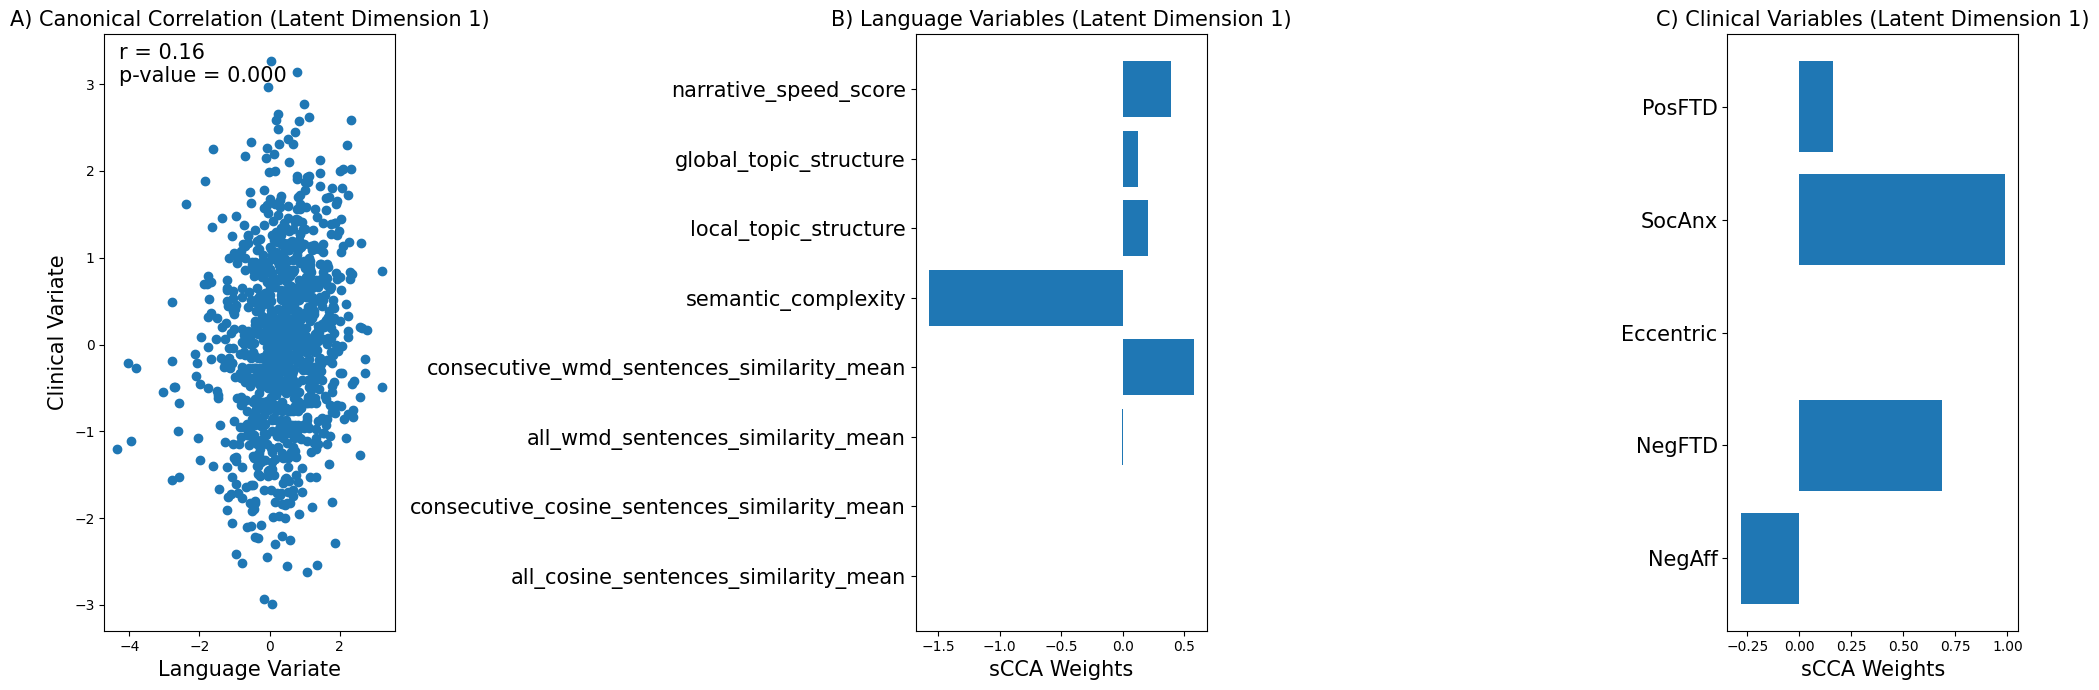

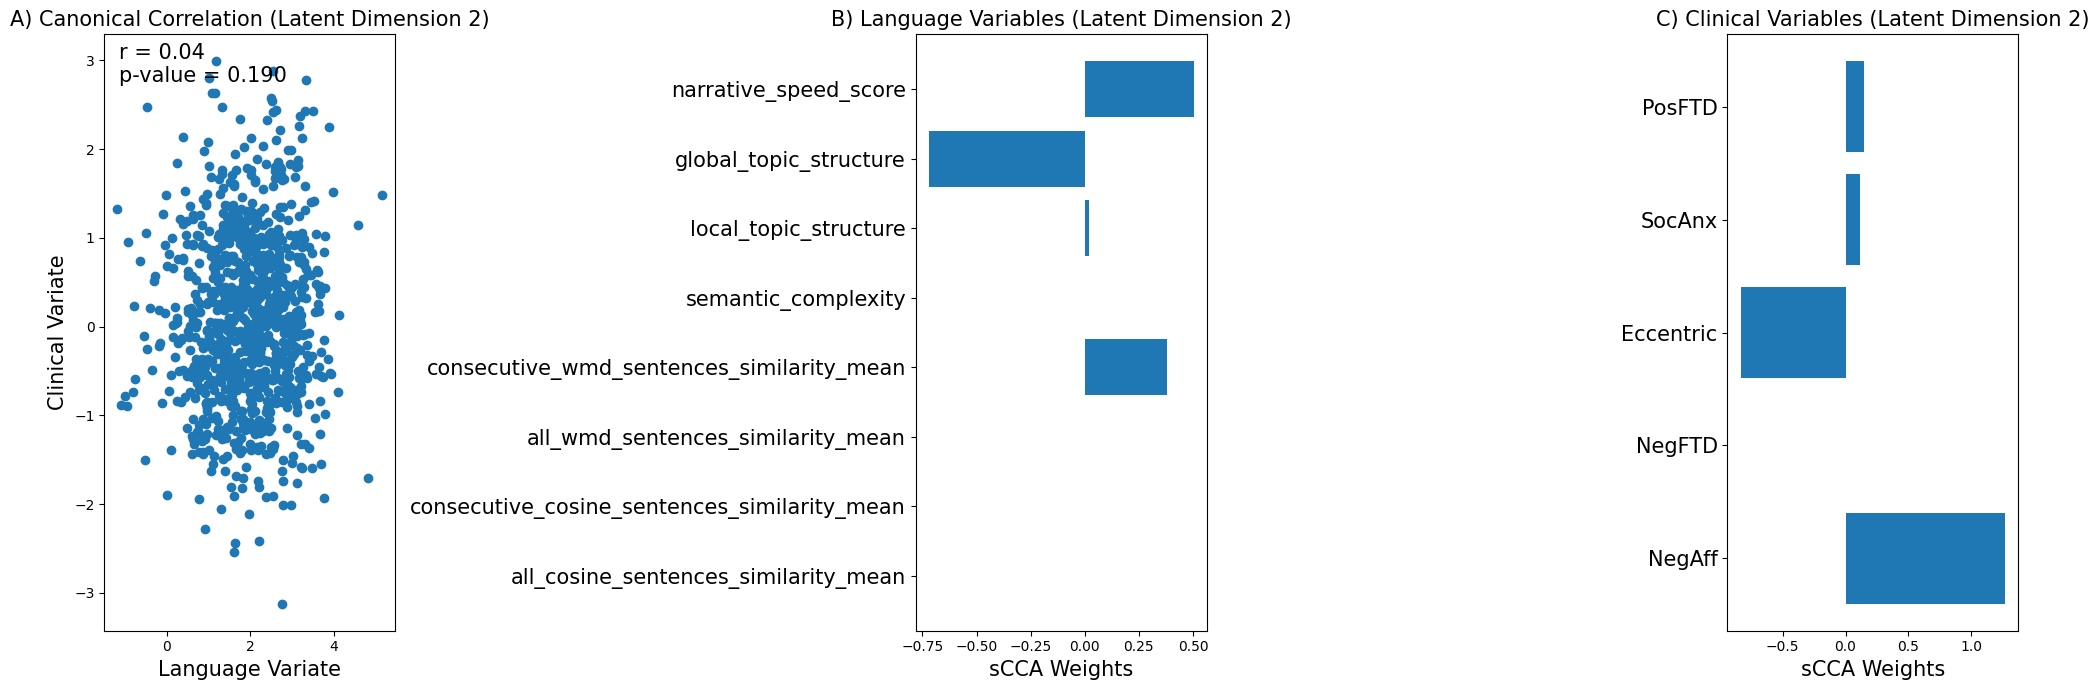

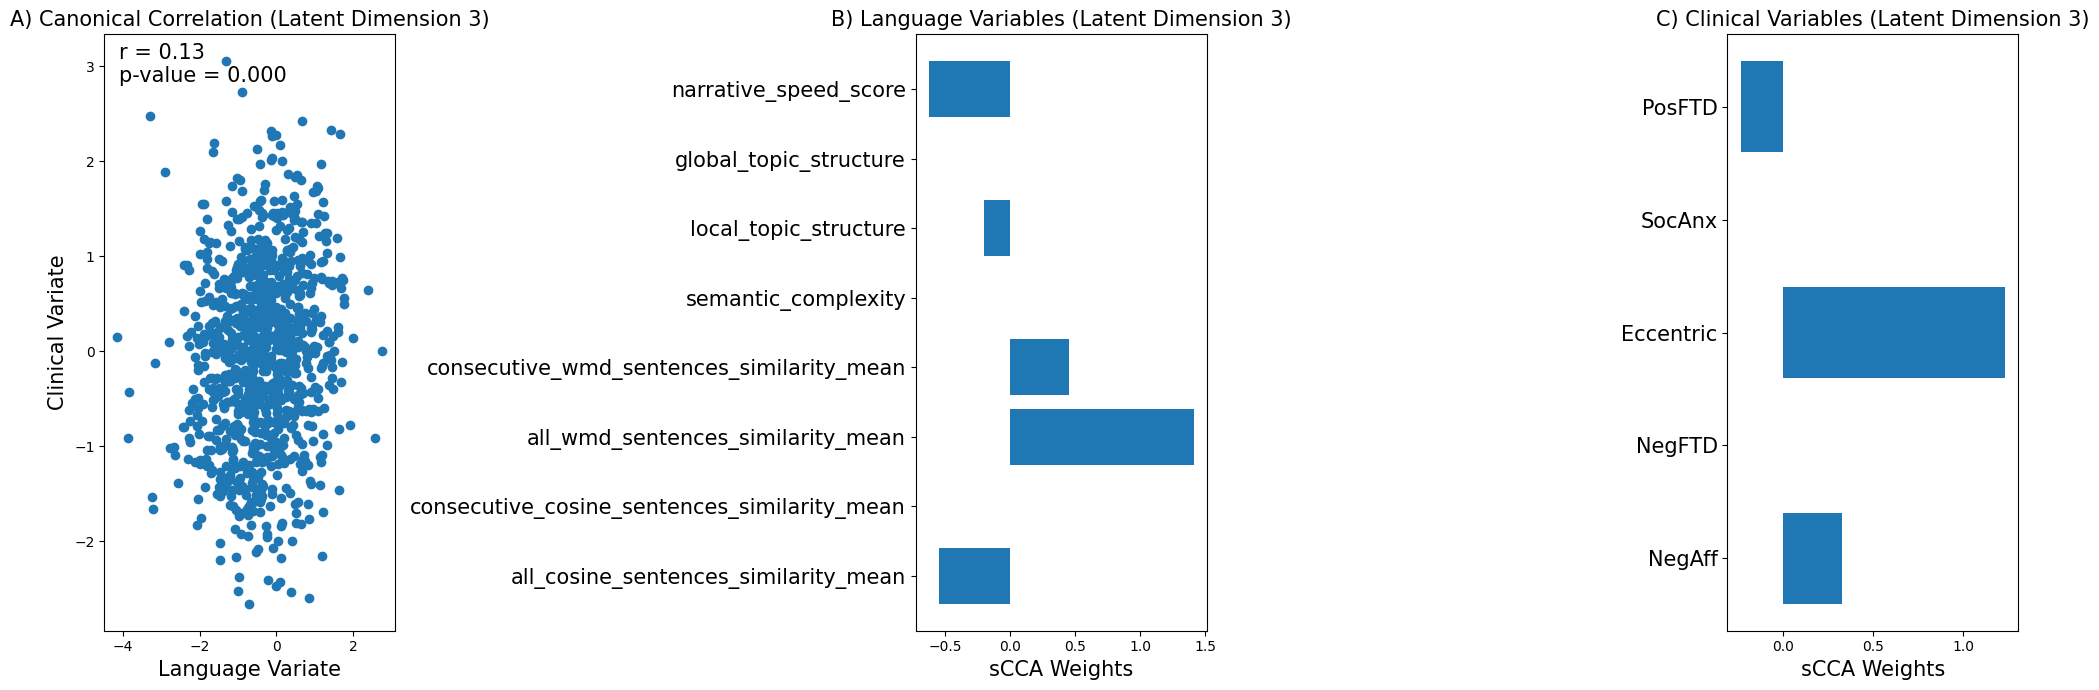

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from cca_zoo.linear import SCCA_IPLS, SCCA_Span, SCCA_Parkhomenko
from cca_zoo.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import contextlib

model_name = "SCCA_IPLS" #"SCCA_Parkhomenko" #'SCCA_SPAN'
constant = 0

# Example data
X = sd_language_features.values + constant
Y = clinical_features.values + constant

# Define 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
outer_correlations = []

# Placeholder for weights and canonical correlations
language_weights_list = []
clinical_weights_list = []
canonical_correlations_list = []

# To keep track of the best model across all folds
best_overall_model = None
best_overall_score = -np.inf
best_overall_params = None

# to keep track of the best weights
best_language_weights = None
best_clinical_weights = None

def canonical_correlation_score(estimator, X, Y):
    score = estimator.score((X, Y))
    return np.abs(score)

# Create a scorer using make_scorer
canonical_correlation_scorer = make_scorer(canonical_correlation_score, greater_is_better=True)

# Outer cross-validation loop
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    # Deal with NaNs
    X_train = np.nan_to_num(X_train)
    X_test = np.nan_to_num(X_test)
    Y_train = np.nan_to_num(Y_train)
    Y_test = np.nan_to_num(Y_test)

    # Define the model with hyperparameter grid search
    

    ipls_param_grid = {
        'alpha': [0.1, 0.5, 1.0],  # regularization parameter
        'l1_ratio': [0,0.1, 0.5, 0.9,1],   # L1/L2 ratio
        "latent_dimensions": [3,4,5,6],
        "random_state" : [42]  # number of canonical components
    }

    span_param_grid = {
    'latent_dimensions': [1, 2,],
    #'tol': [1e-2, 1e-3, 1e-4],
    'regularisation': ['l0', 'l1'],
    #'tau': [0.01,0.1],
    'early_stopping': [False, True],
    'random_state': [42],  # Ensuring reproducibility}
    }

    parkhomenko_param_grid = {
        'latent_dimensions': [1, 2],
        'random_state': [42],  # Ensuring reproducibility
    }

    if model_name == 'SCCA_IPLS':
        model = SCCA_IPLS()
        param_grid = ipls_param_grid

    elif model_name == 'SCCA_SPAN':
        model = SCCA_Span()
        param_grid = span_param_grid
    
    elif model_name == 'SCCA_Parkhomenko':
        model = SCCA_Parkhomenko()
        param_grid = parkhomenko_param_grid
    try:
        with suppress_output():
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring=None, verbose=0)
            grid_search.fit([X_train, Y_train])

        best_model = grid_search.best_estimator_
        best_score = best_model.score([X_test, Y_test])
        print(f"Best hyperparameters: {grid_search.best_params_}")
        print(f"Best training canonical correlation: {best_score}")

        # Update the overall best model if this fold's model is better
        if best_score > best_overall_score:
            best_overall_model = best_model
            best_overall_score = best_score
            best_overall_params = grid_search.best_params_
            best_language_weights = best_model.weights_[0]
            best_clinical_weights = best_model.weights_[1]

        # Train the model on the entire training set with the best hyperparameters
        with suppress_output():
            best_model.fit([X_train, Y_train], verbose=False)

        # Calculate canonical correlations on the test set
        correlation = best_model.score([X_test, Y_test])
        print(f"Test Canonical Correlation: {correlation}")

        # Calculate canonical correlations on the test set for each dimension
        U, V = best_model.transform((X_test, Y_test))
        correlations = [np.corrcoef(U[:, i], V[:, i])[0, 1] for i in range(best_model.latent_dimensions)]
        canonical_correlations_list.append(correlations)
        outer_correlations.append(np.sum(correlations))
        print(f"Test Canonical Correlations manual: {np.sum(correlations)}")

        # Store weights
        language_weights_list.append(best_model.weights_[0])
        clinical_weights_list.append(best_model.weights_[1])
    except Exception as e:
        print(f"Failed: {e}")
        continue

# Convert weights to arrays
#language_weights_shapes = [lw.shape for lw in language_weights_list]
#clinical_weights_shapes = [cw.shape for cw in clinical_weights_list]
#print(f"Language weights shapes: {language_weights_shapes}")
#print(f"Clinical weights shapes: {clinical_weights_shapes}")


# Mean Canonical Correlation
mean_correlation = np.mean(outer_correlations)
print(f"Mean Canonical Correlation: {mean_correlation}")
print(f"Best Overall Hyperparameters: {best_overall_params}")
print(f"Best Overall Training Canonical Correlation: {best_overall_score}")
print("Best Overall  Canonical Correlation: ", best_overall_model.score([X, Y]))


# Function to calculate permutation p-values for each canonical correlation
def permutation_p_values(model, X, Y, n_permutations=5000):
    U, V = model.transform((X, Y))
    original_correlations = [np.corrcoef(U[:, i], V[:, i])[0, 1] for i in range(model.latent_dimensions)]
    permuted_correlations = np.zeros((n_permutations, model.latent_dimensions))

    for i in range(n_permutations):
        permuted_Y = np.random.permutation(Y)
        U_perm, V_perm = model.transform((X, permuted_Y)) # fit transfrom failed and that is why rom cca_zoo.model_selection import permutation_test_score also fail i think
        permuted_correlations[i] = [np.corrcoef(U_perm[:, j], V_perm[:, j])[0, 1] for j in range(model.latent_dimensions)]

    # Calculate p-values
    p_values = np.array([(np.sum(np.abs(permuted_correlations[:, i]) >= np.abs(original_correlations[i]))) / (n_permutations) for i in range(model.latent_dimensions)])
    return original_correlations, p_values

# Calculate p-values using the best overall model
original_correlations, p_values = permutation_p_values(best_overall_model, X, Y, n_permutations=10000)
print(f"Original Correlations: {original_correlations}")
print(f"P-values: {p_values}")

# Compute canonical variates for the scatter plot
X_canonical = X @ best_language_weights
Y_canonical = Y @ best_clinical_weights

font_size = 15

# Scatter plot
for i in range(best_overall_model.latent_dimensions):
    fig, axs = plt.subplots(1, 3, figsize=(20, 7))
    axs[0].scatter(X_canonical[:, i], Y_canonical[:, i])
    axs[0].set_title(f'A) Canonical Correlation (Latent Dimension {i+1})',fontsize=font_size )
    axs[0].set_xlabel('Language Variate', fontsize=font_size)
    axs[0].set_ylabel('Clinical Variate', fontsize=font_size)
    axs[0].annotate(f'r = {original_correlations[i]:.2f}\np-value = {p_values[i]:.3f}',
                    xy=(0.05, 0.92), xycoords='axes fraction', fontsize=font_size)

    # B) Bar plot for language weights
    axs[1].barh(range(X.shape[1]), best_language_weights[:, i])
    axs[1].set_yticks(range(X.shape[1]))
    axs[1].set_yticklabels(language_features.columns.tolist(), fontsize=font_size)
    axs[1].set_title(f'B) Language Variables (Latent Dimension {i+1})', fontsize=font_size)
    axs[1].set_xlabel('sCCA Weights', fontsize=font_size)

    # C) Bar plot for clinical weights
    axs[2].barh(range(Y.shape[1]), best_clinical_weights[:, i])
    axs[2].set_yticks(range(Y.shape[1]))
    axs[2].set_yticklabels(clinical_features.columns.tolist(), fontsize=font_size)
    axs[2].set_title(f'C) Clinical Variables (Latent Dimension {i+1})', fontsize=font_size)
    axs[2].set_xlabel('sCCA Weights', fontsize=font_size)

    plt.tight_layout()
    plt.show()

In [23]:
from src.semantic_density import narrative_speed_score

data['narrative_speed_score_test'] = data['sentence_sim_vectors'].apply(lambda x: narrative_speed_score(x)) 


In [ ]:
for col in density_features :
    sns.lmplot(data=data, y=col, x='num_sentences')
    plt.show()

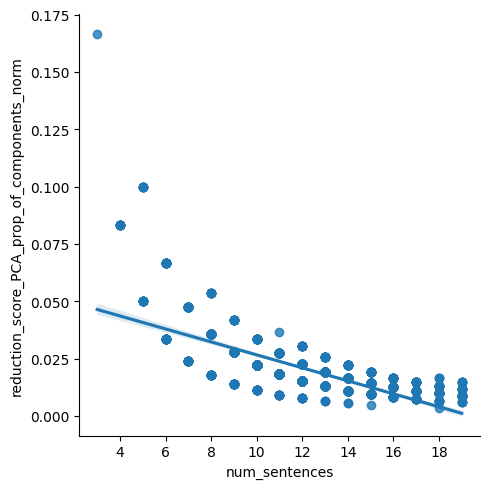

In [7]:
import seaborn as sns
#data['narrative_speed_score_test_2'] = data['narrative_speed_score_test']/ data['sentence_sim_vectors'].apply(lambda x: len(x)**0.18)
data['reduction_score_PCA_prop_of_components_norm'] = data['reduction_score_PCA_prop_of_components'] / data['sentence_sim_vectors'].apply(lambda x: len(x))
sns.lmplot(data=data, y='reduction_score_PCA_prop_of_components_norm', x='num_sentences')

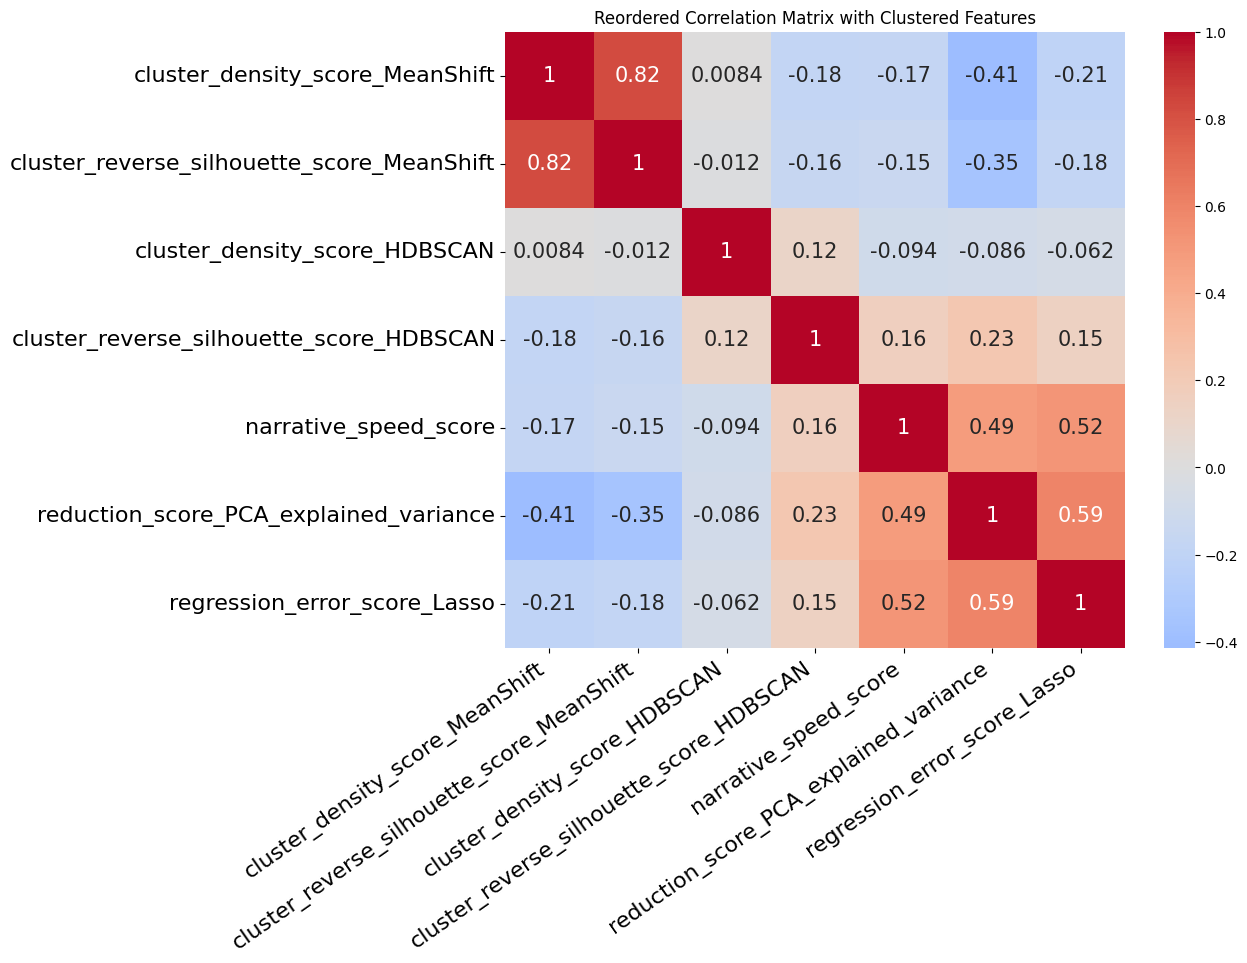

In [8]:
from scipy.cluster.hierarchy import linkage, leaves_list
import seaborn as sns
import matplotlib.pyplot as plt

density = ['narrative_speed_score',
                    'reduction_score_PCA_explained_variance',
                    #'reduction_score_PCA_prop_of_components',
                    'cluster_density_score_HDBSCAN',
                    'cluster_reverse_silhouette_score_HDBSCAN',
                    'cluster_density_score_MeanShift',
                    'cluster_reverse_silhouette_score_MeanShift',
                    #'regression_coef_density_score_Lasso',
                    'regression_error_score_Lasso',
                    #'reduction_score_Lasso'
                    ]

data_dense = routine[density]

corr_matrix = data_dense.corr(method='kendall')

linkage_matrix = linkage(corr_matrix, method='average')

# Step 3: Reorder the correlation matrix
# Get the order of the leaves
order = leaves_list(linkage_matrix)

# Reorder the correlation matrix according to the hierarchical clustering
reordered_corr_matrix = corr_matrix.iloc[order, order]

# Reorder the correlation matrix according to the hierarchical clustering
reordered_corr_matrix = corr_matrix.iloc[order, order]

# Step 4: Visualize the reordered correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(reordered_corr_matrix, annot=True, cmap='coolwarm', center=0, annot_kws={"size": 15})
plt.xticks(rotation=35, ha='right', fontsize=16)  # Change x-axis label font size here
plt.yticks(fontsize=16)
plt.title('Reordered Correlation Matrix with Clustered Features')
plt.show()

In [9]:
import warnings
warnings.filterwarnings('ignore')
from src.stats_analysis import compute_pearson_table
import seaborn as sns

def compute_correlation_table(data, factors = factors, all_features = all_features):
    results = pd.DataFrame()
    for method in ['spearman',"skipped"]:
        r = compute_pearson_table(data, factors,all_features, seuil=0.05, method = method)
        r['method'] = method
        results =  pd.concat([results,r])
    results.reset_index(inplace=True)
    return results

"""features_of_interest = [
    "all_cosine_sentences_similarity_mean",
    "consecutive_cosine_sentences_similarity_mean",
    "all_wmd_sentences_similarity_mean",
] + density_features"""

results_all= compute_correlation_table(data, factors=factors, all_features=features_of_interest)
results_routine = compute_correlation_table(routine, factors=factors, all_features=features_of_interest)
results_cinderella = compute_correlation_table(cinderella, factors=factors, all_features=features_of_interest)

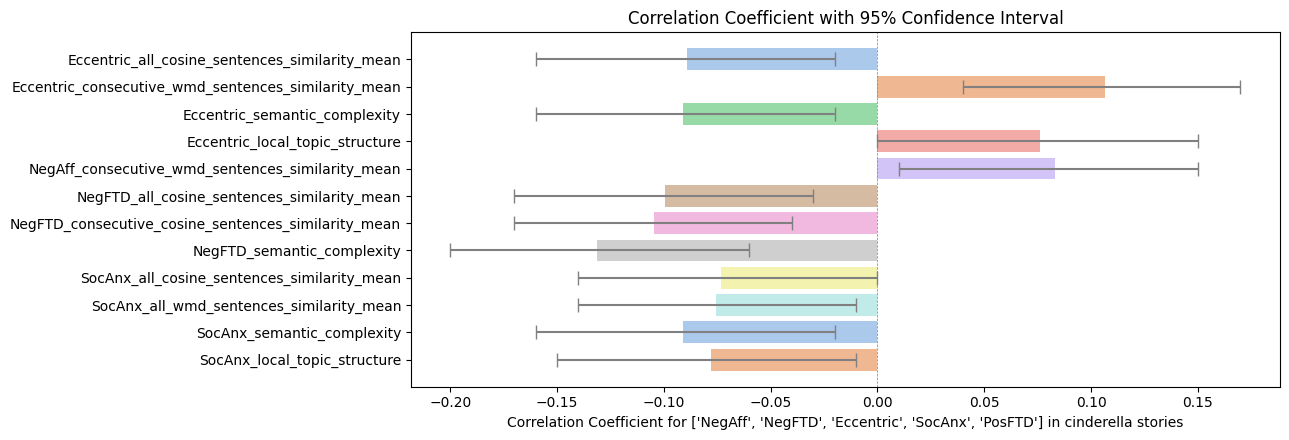

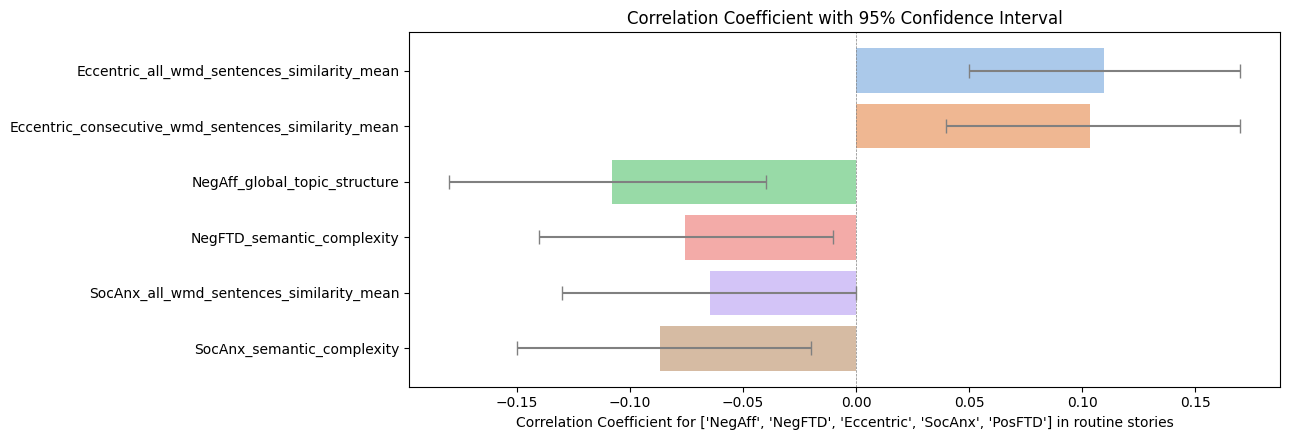

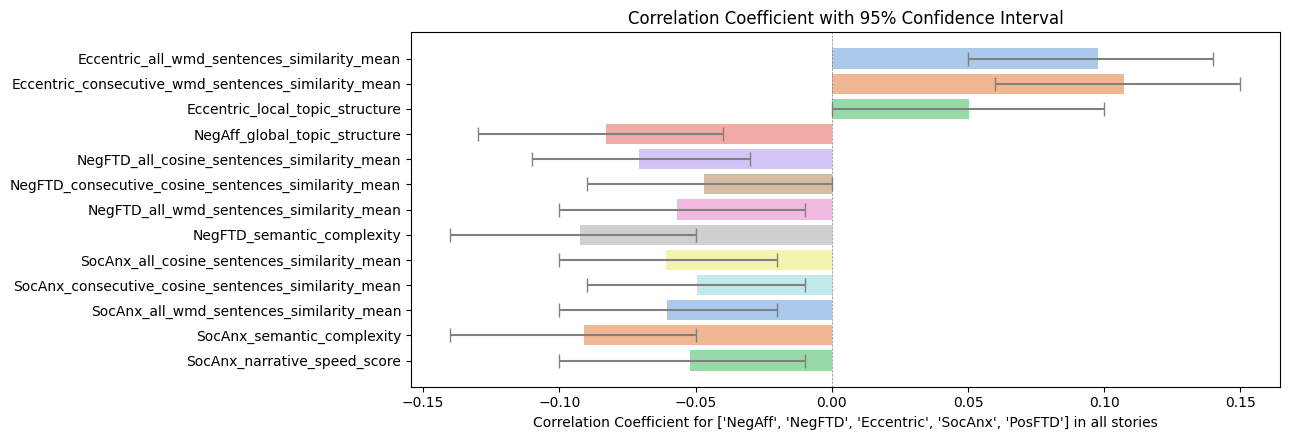

In [10]:
import matplotlib.pyplot as plt

def plot_with_seaborn(df, target_list, name = ""):
    df = df[df['x'].isin(target_list)].sort_values('method')
    # Calculate error bars
    errors = [(coef - ci[0], ci[1] - coef) for coef, ci in zip(df['r'], df['CI95%'])]

    # Plot
    a = max(int(np.sqrt(len(df))),3)
    plt.figure(figsize=(10,a ))

    # Use Seaborn barplot
    sns.barplot(data=df, x='r', y=df.apply(lambda x: f" {x['method']}_{x['y']}", axis=1),
                palette='pastel')

    # Add error bars
    for i, (err, bar) in enumerate(zip(errors, plt.gca().patches)):
        plt.gca().errorbar(bar.get_width(), i, xerr=[[err[0]], [err[1]]], fmt='none', ecolor='gray', capsize=5)

    plt.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)
    plt.title('Correlation Coefficient with 95% Confidence Interval')
    plt.xlabel(f'Correlation Coefficient for {target} in {name} stories')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

def plot_with_seaborn_all(df, target_list, name = ""):
    df = df[df['x'].isin(target_list)].sort_values('x')
    # Calculate error bars
    errors = [(coef - ci[0], ci[1] - coef) for coef, ci in zip(df['r'], df['CI95%'])]

    # Plot
    a = max(int(np.sqrt(len(df))),3)
    plt.figure(figsize=(13,a*1.5 ))

    # Use Seaborn barplot
    sns.barplot(data=df, x='r', y=df.apply(lambda x: f"{x['x']}_{x['y']}", axis=1),
                palette='pastel')

    # Add error bars
    for i, (err, bar) in enumerate(zip(errors, plt.gca().patches)):
        plt.gca().errorbar(bar.get_width(), i, xerr=[[err[0]], [err[1]]], fmt='none', ecolor='gray', capsize=5)

    plt.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)
    plt.title('Correlation Coefficient with 95% Confidence Interval')
    plt.xlabel(f'Correlation Coefficient for {target} in {name} stories')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

"""
meth = "skipped"
for target in factors:
    plot_with_seaborn(results_all[results_all.method ==meth], [target], name="all")

    plot_with_seaborn(results_routine[results_routine.method==meth], [target], name="routine")

    plot_with_seaborn(results_cinderella[results_cinderella.method == meth], [target], name="cinderella")"""
meth = "skipped"

plot_with_seaborn_all(results_cinderella[results_cinderella.method == meth], factors, name="cinderella")
plot_with_seaborn_all(results_routine[results_routine.method == meth], factors, name="routine")
plot_with_seaborn_all(results_all[results_all.method == meth], factors, name="all")


In [27]:
import pingouin as pg

def compute_cohen(score_list, routine,cinderella):
    cohen  = pd.DataFrame(columns=['feature_x','cohen_d'])
    for i,score in enumerate(score_list):
        x = routine[score].tolist()
        y = cinderella[score].tolist()
        d = pg.compute_effsize(y, x, paired=False, eftype='cohen')
        cohen.loc[i] = pd.Series({'feature_x':score, 'feature_y':score, 'cohen_d':d})
    return cohen

cohen_all= compute_cohen(features_of_interest, routine,cinderella)


## Part 2.


In [11]:
features_of_interest

['all_cosine_sentences_similarity_mean',
 'consecutive_cosine_sentences_similarity_mean',
 'all_wmd_sentences_similarity_mean',
 'consecutive_wmd_sentences_similarity_mean',
 'semantic_complexity',
 'local_topic_structure',
 'global_topic_structure',
 'narrative_speed_score']

In [14]:



# Merge the dataframes on the 'id' column
merged_df = pd.merge(cinderella, routine, on='subj', suffixes=('_cinderella', '_routine'))

features_of_interest = all_cosine_sentences_similarity_mean + all_wmd_sentences_similarity_mean + density + ['all_cosine_sentences_similarity_mean',"consecutive_cosine_sentences_similarity_mean","all_wmd_sentences_similarity_mean","consecutive_wmd_sentences_similarity_mean"]

# Calculate the correlation between the corresponding metrics
correlation_results = {}
for col in features_of_interest:
    if col != 'subj':
        correlation = merged_df[f'{col}_cinderella'].corr(merged_df[f'{col}_routine'], method='kendall')
        correlation_results[col] = correlation

# Display the correlation results
correlation_results_df = pd.DataFrame.from_dict(correlation_results, orient='index', columns=['Correlation'])
positive_correlations = correlation_results_df[correlation_results_df['Correlation'] > 0]


correlation_results_df

,Correlation
w2v_all_cosine_sentences_similarity_mean,0.204695
fast_text_all_cosine_sentences_similarity_mean,0.226559
glove_all_cosine_sentences_similarity_mean,0.204377
sentence_sim_all_cosine_sentences_similarity_mean,0.100131
w2v_all_wmd_sentences_similarity_mean,0.183512
fast_text_all_wmd_sentences_similarity_mean,0.159393
glove_all_wmd_sentences_similarity_mean,0.194257
narrative_speed_score,0.077961
reduction_score_PCA_explained_variance,0.156614
cluster_density_score_HDBSCAN,-0.018719


In [27]:
import pingouin as pg
merged_df = pd.merge(cinderella, routine, on='subj', suffixes=('_cinderella', '_routine'))

features_of_interest = all_cosine_sentences_similarity_mean + all_wmd_sentences_similarity_mean + [
    'all_cosine_sentences_similarity_mean', 
    "consecutive_cosine_sentences_similarity_mean", 
    "all_wmd_sentences_similarity_mean", 
    "consecutive_wmd_sentences_similarity_mean"
] + density 

# Define correlation methods to use
correlation_methods = [ 'spearman']# lambda x, y: pg.corr(x, y, method='skipped')['r'].values[0] ]

# Prepare a DataFrame to store results
correlation_results = []

# Calculate correlations for each method and feature
for col in features_of_interest:
    if col != 'subj':
        row = {'Feature': col}
        for method in correlation_methods:
            # Calculate correlation for each method using pandas `corr` function
            try:
                correlation_value = merged_df[f'{col}_cinderella'].corr(merged_df[f'{col}_routine'], method=method)
            except Exception as e:
                print(e)
                correlation_value = None  # If correlation calculation fails, assign None
            row[method] = correlation_value
        correlation_results.append(row)

# Create a DataFrame from the results
correlation_results_df = pd.DataFrame(correlation_results)

# Display only positive correlations if desired
positive_correlations = correlation_results_df[(correlation_results_df[[ 'spearman']] > 0).any(axis=1)]

correlation_results_df

,Feature,spearman
0,w2v_all_cosine_sentences_similarity_mean,0.300653
1,fast_text_all_cosine_sentences_similarity_mean,0.330959
2,glove_all_cosine_sentences_similarity_mean,0.299428
3,sentence_sim_all_cosine_sentences_similarity_mean,0.148411
4,w2v_all_wmd_sentences_similarity_mean,0.271093
5,fast_text_all_wmd_sentences_similarity_mean,0.235818
6,glove_all_wmd_sentences_similarity_mean,0.285113
7,all_cosine_sentences_similarity_mean,0.296554
8,consecutive_cosine_sentences_similarity_mean,0.263465
9,all_wmd_sentences_similarity_mean,0.269107


In [28]:
to_keep = positive_correlations.Feature.tolist()
results_all= compute_correlation_table(data, factors=factors, all_features=to_keep)


In [22]:
from scipy.stats import kendalltau, spearmanr, pearsonr
import pingouin as pg

# Assuming merged_df, features_of_interest are defined as in your code
merged_df = pd.merge(cinderella, routine, on='subj', suffixes=('_cinderella', '_routine'))

features_of_interest = all_cosine_sentences_similarity_mean + all_wmd_sentences_similarity_mean + density + [
    'all_cosine_sentences_similarity_mean', 
    "consecutive_cosine_sentences_similarity_mean", 
    "all_wmd_sentences_similarity_mean", 
    "consecutive_wmd_sentences_similarity_mean"
]

# Define correlation methods to use
correlation_methods = {
    'kendall': kendalltau,
    'spearman': spearmanr,
    'pearson': pearsonr,
    'skipped': lambda x, y: pg.corr(x, y, method='skipped')  # Skipped correlation via pingouin
}

# Prepare a DataFrame to store results
correlation_results = []

# Calculate correlations for each method and feature
for col in features_of_interest:
    if col != 'subj':
        row = {'Feature': col}
        for method_name, method_func in correlation_methods.items():
            # Calculate correlation for each method
            x = merged_df[f'{col}_cinderella']
            y = merged_df[f'{col}_routine']
            try:
                if method_name == 'skipped':  # Special case for skipped correlation (returns a DataFrame)
                    correlation_value = method_func(x, y)
                else:
                    correlation_value, _ = method_func(x, y)
            except Exception as e:
                print(e)
                correlation_value = None  # If correlation calculation fails, assign None
            row[method_name] = correlation_value
        correlation_results.append(row)

# Create a DataFrame from the results
correlation_results_df = pd.DataFrame(correlation_results)

# Display only positive correlations if desired
positive_correlations = correlation_results_df[(correlation_results_df[['kendall', 'spearman', 'pearson', 'skipped']] > 0).any(axis=1)]

correlation_results_df

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [37]:
from cca_zoo.model_selection import permutation_test_score

model = SCCA_IPLS(random_state=best_overall_params['random_state'],
                  alpha=best_overall_params['alpha'],
                   l1_ratio=best_overall_params['l1_ratio'], 
                   latent_dimensions=best_overall_params['latent_dimensions'])

constant = 0

# Example data
X = sd_language_features.values + constant
Y = clinical_features.values + constant

model.fit([X, Y])

score, permutation_scores, p_value = permutation_test_score(model, (X, Y), 
                                                            n_permutations=100, 
                                                            cv =3,
                                                            scoring=None, 
                                                            verbose=1)


# Display the results
print(f"Score on original data: {score}")
print(f"P-value: {p_value}")

# Plotting the permutation scores
plt.hist(perm_scores, bins=50, alpha=0.7, label='Null Distribution')
plt.axvline(score, color='red', linestyle='dashed', linewidth=2, label='Original Score')
plt.legend()
plt.title('Permutation Test for Canonical Correlation')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

Latent Dimension:  33%|███▎      | 1/3 [00:00<00:00, 141.30it/s]


ValueError: Input y contains NaN.

In [98]:
from cca_zoo.model_selection import permutation_test_score
from sklearn.utils import shuffle
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, RobustScaler

scaler_X = RobustScaler()
scaler_Y = RobustScaler()
sd_language_features = pd.DataFrame(scaler_X.fit_transform(dataset[features_list]), columns=language_features.columns.tolist()).fillna(0)
clinical_features = pd.DataFrame(scaler_Y.fit_transform(dataset[factors]), columns=factors).fillna(0)

# Add a small constant to avoid numerical instabilities
small_constant = 1.0e-6



np.random.seed(10)
X = np.random.rand(100,5) + small_constant
Y = np.random.rand(100,5) + small_constant

assert not np.isnan(X).any(), "X contains NaN values"
assert not np.isnan(Y).any(), "Y contains NaN values"

model = SCCA_IPLS(random_state=2, 
                  alpha=best_overall_params['alpha'],
                   l1_ratio=best_overall_params['l1_ratio'], 
                   latent_dimensions=best_overall_params['latent_dimensions'])


def cca_score(model, X_Y):
    X, Y = X_Y
    U, V = model.transform((X, Y))
    canonical_correlations = [np.corrcoef(U[:, i], V[:, i])[0, 1] for i in range(U.shape[1])]
    return np.max(canonical_correlations)

cca_scorer = make_scorer(cca_score, greater_is_better=True, needs_proba=False)


def fit_model(model, X, Y):
    try:
        model.fit((X, Y))
        U, V = model.transform((X, Y))
        return U, V
    except Exception as e:
        print(f"Error during model fitting: {e}")
        return None, None

U, V = fit_model(model, X, Y)

# Check for NaNs in the original fit
if U is None or V is None:
    raise ValueError("Model fitting failed for the original data.")

# Calculate the original canonical correlation for the first dimension
original_corr = np.corrcoef(U[:, 0], V[:, 0])[0, 1]

# Permutation testing
num_permutations = 100
null_distributions = []

for _ in tqdm(range(num_permutations), desc="Permutations"):
    # Shuffle Y values
    Y_permuted = shuffle(Y, random_state=np.random.randint(0, 10000))
    
    # Ensure no NaN values after shuffling
    assert not np.isnan(Y_permuted).any(), "Y_permuted contains NaN values before fitting"

    U_perm, V_perm = fit_model(model, X, Y_permuted)

    # Check for NaNs in the permuted fit
    if U_perm is None or V_perm is None:
        continue  # Skip this permutation if fitting failed

    perm_corr = np.corrcoef(U_perm[:, 0], V_perm[:, 0])[0, 1]
    null_distributions.append(perm_corr)

null_distributions = np.array(null_distributions)
p_value = (np.sum(null_distributions >= original_corr) + 1.0) / (num_permutations + 1)

# Create a DataFrame to display the significant results if any
significant_results = pd.DataFrame({
    'Correlation': [original_corr],
    'p-value': [p_value]
})

# Display the results
print(significant_results)

# Plot the null distribution and original correlation for visualization
plt.hist(null_distributions, bins=50, alpha=0.7, label='Null Distribution')
plt.axvline(original_corr, color='red', linestyle='dashed', linewidth=2, label='Original Correlation')
plt.legend()
plt.title('Null Distribution of Canonical Correlations')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.show()


"""for k in range(1):
    fig, ax = plt.subplots(1, figsize=[12, 8])
    ax.hist(perm_scores)
    ax.axvline(score, ls="--", color="r")
    
    score_label = f"Score on original\ndata: {score:.2f}\n(p-value: {p_values:.3f})"
    ax.text(0.05, 0.8, score_label, fontsize=12, transform=ax.transAxes)
    ax.set_xlabel("Correlation")
    _ = ax.set_ylabel("Frequency")
    ax.set_title(f"Dimension {k + 1}")
    plt.tight_layout()
    plt.show()"""

Latent Dimension:  50%|█████     | 1/2 [00:00<00:00, 147.10it/s]

Error during model fitting: Input y contains NaN.


ValueError: Model fitting failed for the original data.

Permutations: 100%|██████████| 100/100 [00:00<00:00, 127.62it/s]


   Correlation   p-value
0     0.102917  0.514851


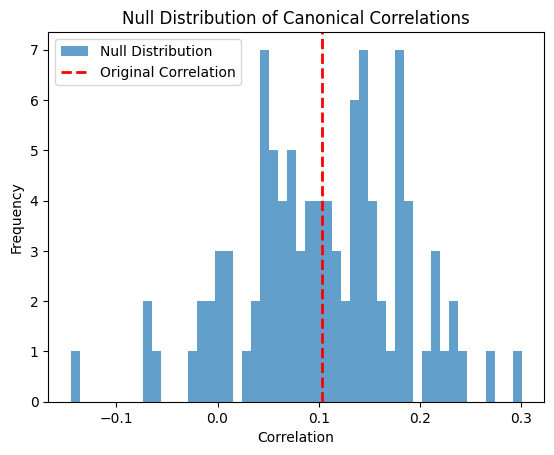

In [119]:
import numpy as np
import pandas as pd
from cca_zoo.linear import SCCA_IPLS, SCCA_Span
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tqdm import tqdm
from sklearn.metrics import make_scorer

# Initialize random data with a small constant added to avoid numerical instability
np.random.seed(10)
small_constant =  0#0.000001 # 10
X = np.random.rand(100, 5) + small_constant
Y = np.random.rand(100, 5) + small_constant

assert not np.isnan(X).any(), "X contains NaN values"
assert not np.isnan(Y).any(), "Y contains NaN values"

# Dummy best parameters
best_overall_params = {
    'alpha': 0.1,
    'l1_ratio': 0.1,
    'latent_dimensions': 2
}

# Initialize the SCCA_IPLS model
model = SCCA_Span(random_state=2, 
                  latent_dimensions=best_overall_params['latent_dimensions'])

def cca_score(model, X_Y):
    X, Y = X_Y
    U, V = model.transform((X, Y))
    canonical_correlations = [np.corrcoef(U[:, i], V[:, i])[0, 1] for i in range(U.shape[1])]
    return np.max(canonical_correlations)

cca_scorer = make_scorer(cca_score, greater_is_better=True, needs_proba=False)

def fit_model(model, X, Y):
    try:
        model.fit((X, Y))
        U, V = model.transform((X, Y))
        return U, V
    except Exception as e:
        print(f"Error during model fitting: {e}")
        return None, None

U, V = fit_model(model, X, Y)

# Check for NaNs in the original fit
if U is None or V is None:
    raise ValueError("Model fitting failed for the original data.")

# Calculate the original canonical correlation for the first dimension
original_corr = np.corrcoef(U[:, 0], V[:, 0])[0, 1]

# Permutation testing
num_permutations = 100
null_distributions = []

for _ in tqdm(range(num_permutations), desc="Permutations"):
    # Shuffle Y values
    Y_permuted = shuffle(Y, random_state=np.random.randint(0, 10000))
    
    # Ensure no NaN values after shuffling
    assert not np.isnan(Y_permuted).any(), "Y_permuted contains NaN values before fitting"

    U_perm, V_perm = fit_model(model, X, Y_permuted)

    # Check for NaNs in the permuted fit
    if U_perm is None or V_perm is None:
        print("Skipping permutation due to fitting error")
        continue  # Skip this permutation if fitting failed

    perm_corr = np.corrcoef(U_perm[:, 0], V_perm[:, 0])[0, 1]
    null_distributions.append(perm_corr)

# Check if null_distributions is empty
if not null_distributions:
    raise ValueError("All permutations failed.")

null_distributions = np.array(null_distributions)
p_value = (np.sum(null_distributions >= original_corr) + 1.0) / (num_permutations + 1)

# Create a DataFrame to display the significant results if any
significant_results = pd.DataFrame({
    'Correlation': [original_corr],
    'p-value': [p_value]
})

# Display the results
print(significant_results)

# Plot the null distribution and original correlation for visualization
plt.hist(null_distributions, bins=50, alpha=0.7, label='Null Distribution')
plt.axvline(original_corr, color='red', linestyle='dashed', linewidth=2, label='Original Correlation')
plt.legend()
plt.title('Null Distribution of Canonical Correlations')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.show()

Best hyperparameters: {'alpha': 0.1, 'l1_ratio': 0.1, 'latent_dimensions': 1}
Best training canonical correlation: 0.22077515429308825
Test Canonical Correlation: 0.09229416415683778
Test Canonical Correlations manual: 0.09229416415683776
Best hyperparameters: {'alpha': 0.1, 'l1_ratio': 0.1, 'latent_dimensions': 1}
Best training canonical correlation: 0.23603600354493515
Test Canonical Correlation: 0.0847800275720445
Test Canonical Correlations manual: 0.08478002757204434
Best hyperparameters: {'alpha': 0.1, 'l1_ratio': 0.5, 'latent_dimensions': 2}
Best training canonical correlation: 0.2909948548645127
Test Canonical Correlation: 0.22525424465539512
Test Canonical Correlations manual: 0.22525424465539512
Best hyperparameters: {'alpha': 0.1, 'l1_ratio': 0.1, 'latent_dimensions': 2}
Best training canonical correlation: 0.3533825140318294
Test Canonical Correlation: 0.18677174930125195
Test Canonical Correlations manual: 0.18677174930125176
Best hyperparameters: {'alpha': 0.1, 'l1_ratio'

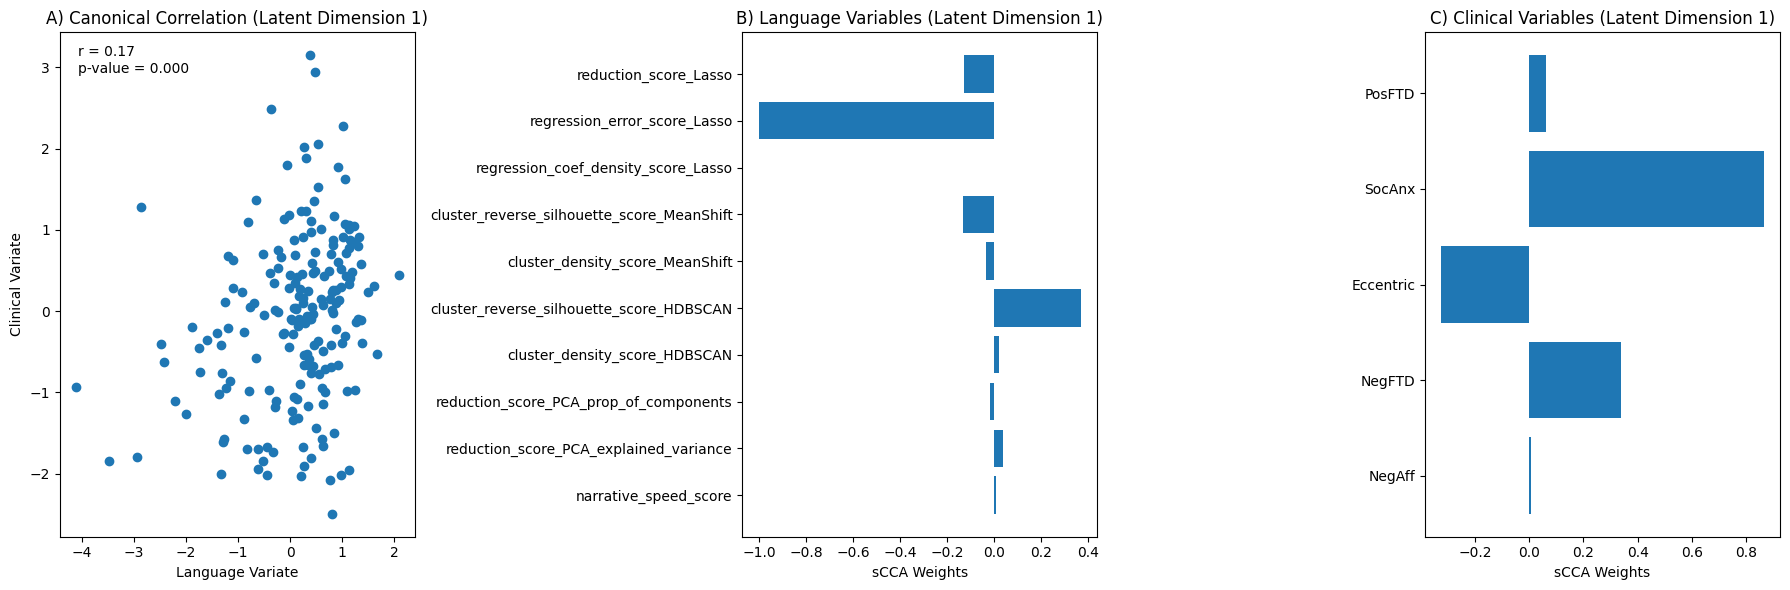

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from cca_zoo.linear import SCCA_IPLS, SCCA_Parkhomenko, SCCA_Span
from cca_zoo.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Example data


X = sd_language_features.values
#Y =  np.random.rand(2006,len(factors)) #clinical_features.values

Y = clinical_features.values 


# Define 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
outer_correlations = []

# Placeholder for weights
language_weights_list = []
clinical_weights_list = []
canonical_correlations_list = []



def canonical_correlation_score(estimator, X, Y):
    score = estimator.score((X, Y))
    return score

# Create a scorer using make_scorer
canonical_correlation_scorer = make_scorer(canonical_correlation_score, greater_is_better=True)

# Outer cross-validation loop
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    # deal with nan
    X_train = np.nan_to_num(X_train)
    X_test = np.nan_to_num(X_test)
    Y_train = np.nan_to_num(Y_train)
    Y_test = np.nan_to_num(Y_test)
   

      
    # Define the model with hyperparameter grid search
    model = SCCA_IPLS(random_state=2) #SCCA_Parkhomenko() #SCCA_IPLS()

    param_grid = {
        'alpha': [0.1, 0.5, 1.0],  # regularization parameter
        'l1_ratio': [0.1, 0.5, 0.9],   # L1/L2 ratio
        "latent_dimensions": [ 1,2] # number of canonical components
    }
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring=None, verbose=0)
    
    with suppress_output():
        grid_search.fit([X_train, Y_train])

    best_model = grid_search.best_estimator_
    print(f"Best hyperparameters: {grid_search.best_params_}")
    print(f"Best training canonical correlation: {best_model.score([X_train, Y_train])}")

    # Train the model on the entire training set with the best hyperparameters
    with suppress_output():
        best_model.fit([X_train, Y_train],verbose=False)

   

    # Calculate canonical correlations on the test set
    correlation = best_model.score([X_test, Y_test])
    print(f"Test Canonical Correlation: {correlation}")
    #outer_correlations.append(correlation)

    # Calculate canonical correlations on the test set for each dimentions
    U, V = best_model.transform((X_test, Y_test))
    correlations = [np.corrcoef(U[:, i], V[:, i])[0, 1] for i in range(best_model.latent_dimensions)]
    canonical_correlations_list.append(correlations)
    outer_correlations.append(np.sum(correlations))
    print(f"Test Canonical Correlations manual: {np.sum(correlations)}")

    # Store weights
    language_weights_list.append(best_model.weights_[0])
    clinical_weights_list.append(best_model.weights_[1])



# Convert weights to arrays
# Check consistency of stored weights
language_weights_shapes = [lw.shape for lw in language_weights_list]
clinical_weights_shapes = [cw.shape for cw in clinical_weights_list]
#print(f"Language weights shapes: {language_weights_shapes}")
#print(f"Clinical weights shapes: {clinical_weights_shapes}")

# Mean Canonical Correlation
mean_correlation = np.mean(outer_correlations)
print(f"Mean Canonical Correlation: {mean_correlation}")

# Ensure consistent shape before averaging
language_weights = np.mean([lw for lw in language_weights_list if lw.shape == language_weights_list[0].shape], axis=0)
clinical_weights = np.mean([cw for cw in clinical_weights_list if cw.shape == clinical_weights_list[0].shape], axis=0)
# Plotting results

# A) Scatter plot of canonical variates


# Compute canonical variates for the scatter plot


# Function to calculate permutation p-values for each canonical correlation
def permutation_p_values(model, X, Y, n_permutations=10000):
    U, V = model.transform((X, Y))
    original_correlations = [np.corrcoef(U[:, i], V[:, i])[0, 1] for i in range(model.latent_dimensions)]
    permuted_correlations = np.zeros((n_permutations, model.latent_dimensions))

    for i in range(n_permutations):
        permuted_Y = np.random.permutation(Y)
        U_perm, V_perm = model.transform((X, permuted_Y))
        permuted_correlations[i] = [np.corrcoef(U_perm[:, j], V_perm[:, j])[0, 1] for j in range(model.latent_dimensions)]

    # Calculate p-values and add a small constant
    p_values = np.array([(np.sum(np.abs(permuted_correlations[:, i]) >= original_correlations[i]) ) / (n_permutations )
                         for i in range(model.latent_dimensions)])
    return original_correlations, p_values

# Calculate p-values
original_correlations, p_values = permutation_p_values(best_model, X, Y, n_permutations=5000)
print(f"Original Correlations: {original_correlations}")
print(f"P-values: {p_values}")


X_test_canonical = X_test @ language_weights
Y_test_canonical = Y_test @ clinical_weights

# Scatter plot
for i in range(best_model.latent_dimensions):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].scatter(X_test_canonical[:, i], Y_test_canonical[:, i])
    axs[0].set_title(f'A) Canonical Correlation (Latent Dimension {i+1})')
    axs[0].set_xlabel('Language Variate')
    axs[0].set_ylabel('Clinical Variate')
    axs[0].annotate(f'r = {original_correlations[i]:.2f}\np-value = {p_values[i]:.3f}', xy=(0.05, 0.92), xycoords='axes fraction')

    # B) Bar plot for language weights
    axs[1].barh(range(X.shape[1]), language_weights[:, i])
    axs[1].set_yticks(range(X.shape[1]))
    axs[1].set_yticklabels(language_features.columns.tolist())
    axs[1].set_title(f'B) Language Variables (Latent Dimension {i+1})')
    axs[1].set_xlabel('sCCA Weights')

    # C) Bar plot for clinical weights
    axs[2].barh(range(Y.shape[1]), clinical_weights[:, i])
    axs[2].set_yticks(range(Y.shape[1]))
    axs[2].set_yticklabels(clinical_features.columns.tolist())
    axs[2].set_title(f'C) Clinical Variables (Latent Dimension {i+1})')
    axs[2].set_xlabel('sCCA Weights')

    plt.tight_layout()
    plt.show()


In [20]:
from cca_zoo.model_selection import permutation_test_score

cv = KFold(n_splits=3, shuffle=True, random_state=42)
# Permutation testing using permutation_test_score
score, perm_scores, p_values = permutation_test_score(
    best_model, (X, Y), cv=cv, n_permutations=1000, n_jobs=1, random_state=0,)

fig, ax = plt.subplots(1, figsize=[12, 8])
for k in range(2):
    ax.hist(perm_scores)
    ax.axvline(score, ls="--", color="r")
    
    score_label = f"Score on original\ndata: {score:.2f}\n(p-value: {p_values:.3f})"
    ax.text(0.05, 0.8, score_label, fontsize=12, transform=ax.transAxes)
    ax.set_xlabel("Correlation")
    _ = ax.set_ylabel("Frequency")
    ax.set_title(f"Dimension {k + 1}")
plt.tight_layout()
plt.show()

(193, 2)

Latent Dimension:   0%|          | 0/1 [00:00<?, ?it/s]

Latent Dimension: 100%|██████████| 2/2 [00:00<00:00, 93.21it/s]


Best hyperparameters: {'alpha': 0.5, 'l1_ratio': 0.1, 'latent_dimensions': 2}
Best canonical correlation: 0.16600503895980245


Latent Dimension: 100%|██████████| 2/2 [00:00<00:00, 89.68it/s]


Best hyperparameters: {'alpha': 0.5, 'l1_ratio': 0.1, 'latent_dimensions': 2}
Best canonical correlation: 0.23818609220950568


Latent Dimension: 100%|██████████| 2/2 [00:00<00:00, 73.34it/s]


Best hyperparameters: {'alpha': 0.5, 'l1_ratio': 0.1, 'latent_dimensions': 2}
Best canonical correlation: 0.1359556194085232


Latent Dimension: 100%|██████████| 2/2 [00:00<00:00, 57.45it/s]


Best hyperparameters: {'alpha': 0.5, 'l1_ratio': 0.1, 'latent_dimensions': 2}
Best canonical correlation: 0.03788599338248603


Latent Dimension: 100%|██████████| 2/2 [00:00<00:00, 82.07it/s]


Best hyperparameters: {'alpha': 0.1, 'l1_ratio': 0.5, 'latent_dimensions': 2}
Best canonical correlation: 0.08177899567864559


Latent Dimension: 100%|██████████| 2/2 [00:00<00:00, 51.66it/s]


Mean Canonical Correlation: 0.1137046798128348
Original Correlations: [0.16064417571132433, 0.14751154359706356]
P-values: [0. 0.]


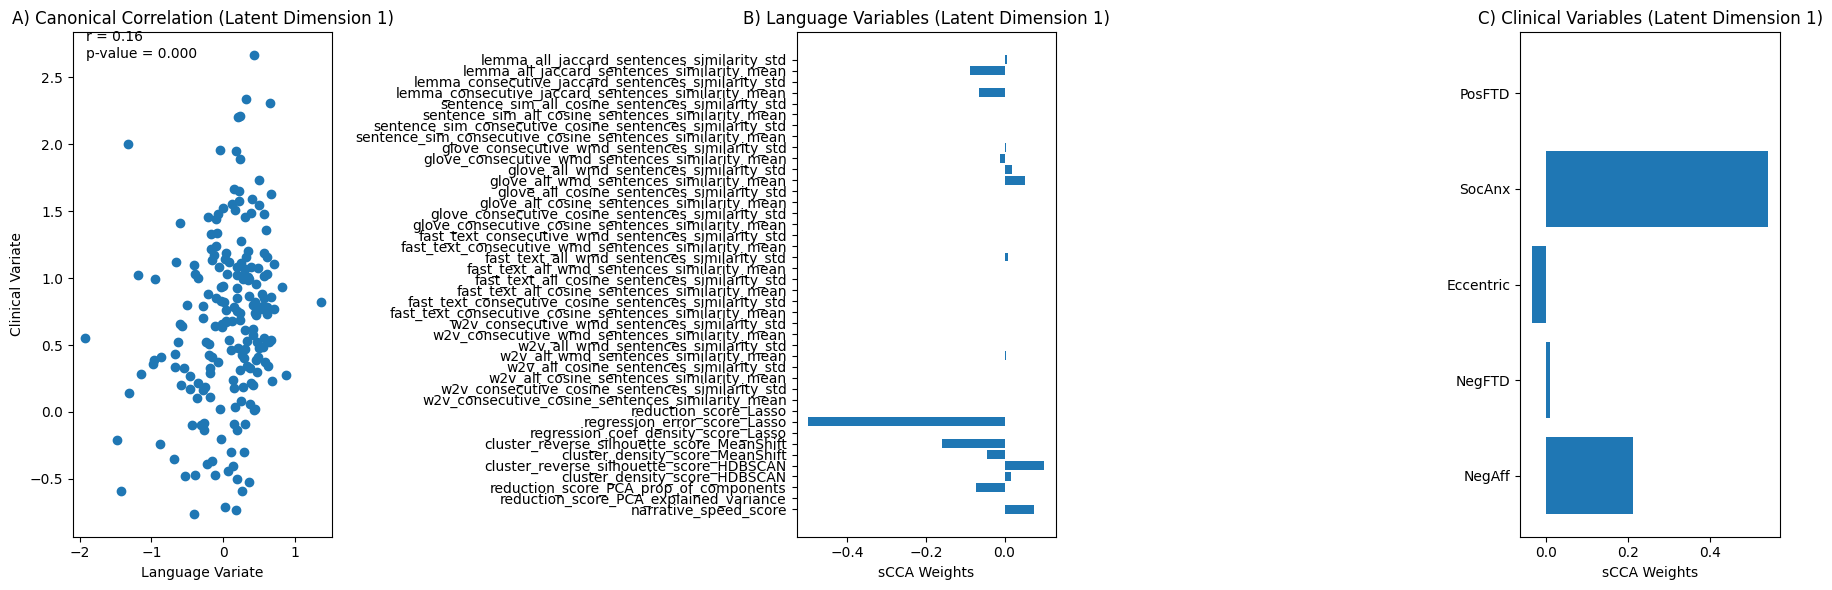

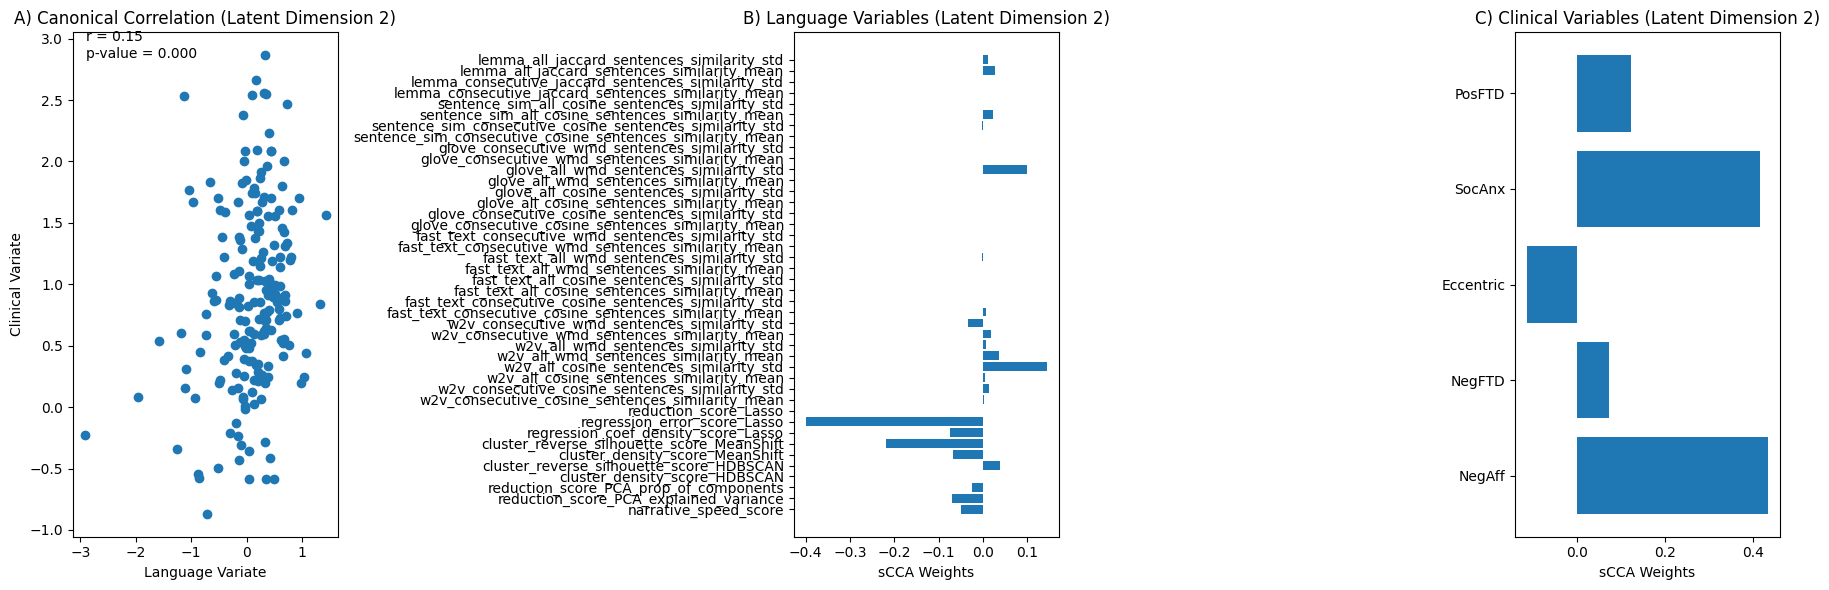

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from cca_zoo.linear import SCCA_IPLS, SCCA_Parkhomenko, SCCA_Span
from cca_zoo.model_selection import GridSearchCV, permutation_test_score

# Example data
X = sd_language_features.values
Y = clinical_features.values

# Define 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
outer_correlations = []

# Placeholder for weights and canonical correlations
language_weights_list = []
clinical_weights_list = []
canonical_correlations_list = []

# Outer cross-validation loop
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    # Inner 3-fold cross-validation for hyperparameter tuning
    inner_kf = KFold(n_splits=3, shuffle=True, random_state=42,)

    # Define the model with hyperparameter grid search
    model = SCCA_IPLS(random_state=2,verbose=False) #SCCA_Parkhomenko() #SCCA_IPLS(
    param_grid = {
        'alpha': [0.1, 0.5, 1.0],  # regularization parameter
        'l1_ratio': [0.1, 0.5, 0.9],   # L1/L2 ratio
        "latent_dimensions": [1, 2]  # number of canonical components
    }

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_kf,verbose=False)
    grid_search.fit([X_train, Y_train])

    best_model = grid_search.best_estimator_
    print(f"Best hyperparameters: {grid_search.best_params_}")
    print(f"Best canonical correlation: {grid_search.best_score_}")

    # Train the model on the entire training set with the best hyperparameters
    best_model.fit([X_train, Y_train])

    # Calculate canonical correlations on the test set
    U, V = best_model.transform((X_test, Y_test))
    correlations = [np.corrcoef(U[:, i], V[:, i])[0, 1] for i in range(best_model.latent_dimensions)]
    canonical_correlations_list.append(correlations)
    outer_correlations.append(np.mean(correlations))

    # Store weights
    language_weights_list.append(best_model.weights_[0])
    clinical_weights_list.append(best_model.weights_[1])

# Mean Canonical Correlation
mean_correlation = np.mean(outer_correlations)
print(f"Mean Canonical Correlation: {mean_correlation}")

# Convert weights to arrays
language_weights = np.array(language_weights_list).mean(axis=0)
clinical_weights = np.array(clinical_weights_list).mean(axis=0)
canonical_correlations = np.array(canonical_correlations_list).mean(axis=0)

# Function to calculate permutation p-values for each canonical correlation
def permutation_p_values(model, X, Y, n_permutations=10000):
    U, V = model.transform((X, Y))
    original_correlations = [np.corrcoef(U[:, i], V[:, i])[0, 1] for i in range(model.latent_dimensions)]
    permuted_correlations = np.zeros((n_permutations, model.latent_dimensions))

    for i in range(n_permutations):
        permuted_Y = np.random.permutation(Y)
        U_perm, V_perm = model.transform((X, permuted_Y))
        permuted_correlations[i] = [np.corrcoef(U_perm[:, j], V_perm[:, j])[0, 1] for j in range(model.latent_dimensions)]

    # Calculate p-values and add a small constant
    p_values = np.array([(np.sum(np.abs(permuted_correlations[:, i]) >= original_correlations[i]) ) / (n_permutations )
                         for i in range(model.latent_dimensions)])
    return original_correlations, p_values

# Calculate p-values
original_correlations, p_values = permutation_p_values(best_model, X, Y, n_permutations=10000)
print(f"Original Correlations: {original_correlations}")
print(f"P-values: {p_values}")

# Plotting results

# Compute canonical variates for the scatter plot
X_test_canonical = X_test @ language_weights
Y_test_canonical = Y_test @ clinical_weights

# Scatter plot
for i in range(best_model.latent_dimensions):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].scatter(X_test_canonical[:, i], Y_test_canonical[:, i])
    axs[0].set_title(f'A) Canonical Correlation (Latent Dimension {i+1})')
    axs[0].set_xlabel('Language Variate')
    axs[0].set_ylabel('Clinical Variate')
    axs[0].annotate(f'r = {original_correlations[i]:.2f}\np-value = {p_values[i]:.3f}', xy=(0.05, 0.95), xycoords='axes fraction')

    # B) Bar plot for language weights
    axs[1].barh(range(X.shape[1]), language_weights[:, i])
    axs[1].set_yticks(range(X.shape[1]))
    axs[1].set_yticklabels(language_features.columns.tolist())
    axs[1].set_title(f'B) Language Variables (Latent Dimension {i+1})')
    axs[1].set_xlabel('sCCA Weights')

    # C) Bar plot for clinical weights
    axs[2].barh(range(Y.shape[1]), clinical_weights[:, i])
    axs[2].set_yticks(range(Y.shape[1]))
    axs[2].set_yticklabels(clinical_features.columns.tolist())
    axs[2].set_title(f'C) Clinical Variables (Latent Dimension {i+1})')
    axs[2].set_xlabel('sCCA Weights')

    plt.tight_layout()
    plt.show()


In [8]:
U, V = best_model.transform((X, Y))

canonical_corr = np.corrcoef(U[:, 0], Y.T)[0, 1:]
top_indices = np.argsort(np.abs(canonical_corr))[-20:]  # Top 20 correlated indices
top_questions = clinical_features.columns[top_indices]
top_correlations = canonical_corr[top_indices]

top_results = pd.DataFrame({
    'Clinical Question': top_questions,
    'Correlation': top_correlations
}).sort_values(by='Correlation', ascending=False)

top_results

,Clinical Question,Correlation
4,NegFTD,0.120059
3,SocAnx,0.102763
0,PosFTD,-0.003264
1,Eccentric,-0.034311
2,NegAff,-0.035501


In [9]:
canonical_corr = np.corrcoef(V[:, 0], X.T)[0, 1:]

# Identify the top 20 correlated language features
top_indices = np.argsort(np.abs(canonical_corr))[-20:]  # Top 20 correlated indices
top_features = language_features.columns[top_indices]
top_correlations = canonical_corr[top_indices]

# Create a DataFrame with the top correlated language features
top_results = pd.DataFrame({
    'Language Feature': top_features,
    'Correlation': top_correlations
}).sort_values(by='Correlation', ascending=False)

# Output the DataFrame
top_results


,Language Feature,Correlation
7,regression_coef_density_score_Lasso,0.083962
6,cluster_density_score_HDBSCAN,0.062247
5,cluster_reverse_silhouette_score_HDBSCAN,0.059752
4,cluster_density_score_MeanShift,0.059195
3,cluster_reverse_silhouette_score_MeanShift,0.054971
1,narrative_speed_score,0.026215
0,reduction_score_PCA_prop_of_components,-0.000376
2,reduction_score_Lasso,-0.037530
8,reduction_score_PCA_explained_variance,-0.085663
9,regression_error_score_Lasso,-0.120520


In [14]:
loadings = best_model.loadings_((X,Y))
language_loadings, clinical_loadings = loadings

# Print the canonical loadings for each view
language_loadings_df = pd.DataFrame(language_loadings, index=language_features.columns, columns=[f'LatentDim_{i+1}' for i in range(language_loadings.shape[1])])
clinical_loadings_df = pd.DataFrame(clinical_loadings, index=clinical_features.columns, columns=[f'LatentDim_{i+1}' for i in range(clinical_loadings.shape[1])])

print("Language Feature Loadings DataFrame:\n", language_loadings_df)
print("Clinical Feature Loadings DataFrame:\n", clinical_loadings_df)

Language Feature Loadings DataFrame:
                                             LatentDim_1  LatentDim_2
narrative_speed_score                          0.276434     0.818092
reduction_score_PCA_explained_variance        -0.648367    -0.121481
reduction_score_PCA_prop_of_components         0.020715     0.727594
cluster_density_score_HDBSCAN                  0.307235    -0.245611
cluster_reverse_silhouette_score_HDBSCAN       0.190420    -0.330216
cluster_density_score_MeanShift                0.523364     0.386347
cluster_reverse_silhouette_score_MeanShift     0.491949     0.273081
regression_coef_density_score_Lasso            0.436820     0.189275
regression_error_score_Lasso                  -0.642239     0.467202
reduction_score_Lasso                         -0.403663    -0.234382
Clinical Feature Loadings DataFrame:
            LatentDim_1  LatentDim_2
NegAff       -0.191757    -0.036737
NegFTD        0.690873    -0.054719
Eccentric    -0.165262     0.701095
SocAnx        0.45859

In [15]:
def canonical_loadings(X, U):
    # Calculate the correlation between each column of X and U
    loadings = np.corrcoef(X.T, U.T)[:X.shape[1], X.shape[1]:]
    return loadings

language_loadings = canonical_loadings(X, U)
clinical_loadings = canonical_loadings(Y, V)

# Print the canonical loadings for each view
print("Language Feature Loadings:\n", language_loadings)
print("Clinical Feature Loadings:\n", clinical_loadings)

Language Feature Loadings:
 [[ 0.27643421  0.81809201]
 [-0.64836721 -0.12148143]
 [ 0.02071459  0.72759393]
 [ 0.30723484 -0.24561085]
 [ 0.19041951 -0.33021628]
 [ 0.52336383  0.38634697]
 [ 0.49194934  0.27308099]
 [ 0.43682032  0.18927475]
 [-0.64223934  0.46720175]
 [-0.40366256 -0.23438196]]
Clinical Feature Loadings:
 [[-0.19175721 -0.03673689]
 [ 0.69087322 -0.05471912]
 [-0.16526244  0.70109549]
 [ 0.45859095 -0.58118377]
 [-0.31399517  0.15645896]]


2

In [16]:
from cca_zoo.model_selection import permutation_test_score

cv = KFold(n_splits=3, shuffle=True, random_state=42)
# Permutation testing using permutation_test_score
score, perm_scores, p_values = permutation_test_score(
    best_model, (X, Y), cv=cv, n_permutations=1000, n_jobs=1, random_state=0,)

fig, ax = plt.subplots(1, figsize=[12, 8])
for k in range(2):
    ax.hist(perm_scores)
    ax.axvline(score, ls="--", color="r")
    
    score_label = f"Score on original\ndata: {score:.2f}\n(p-value: {p_values:.3f})"
    ax.text(0.05, 0.8, score_label, fontsize=12, transform=ax.transAxes)
    ax.set_xlabel("Correlation")
    _ = ax.set_ylabel("Frequency")
    ax.set_title(f"Dimension {k + 1}")
plt.tight_layout()
plt.show()


Latent Dimension: 100%|██████████| 2/2 [00:00<00:00, 287.15it/s]


In [26]:
score

0.13408852919351466

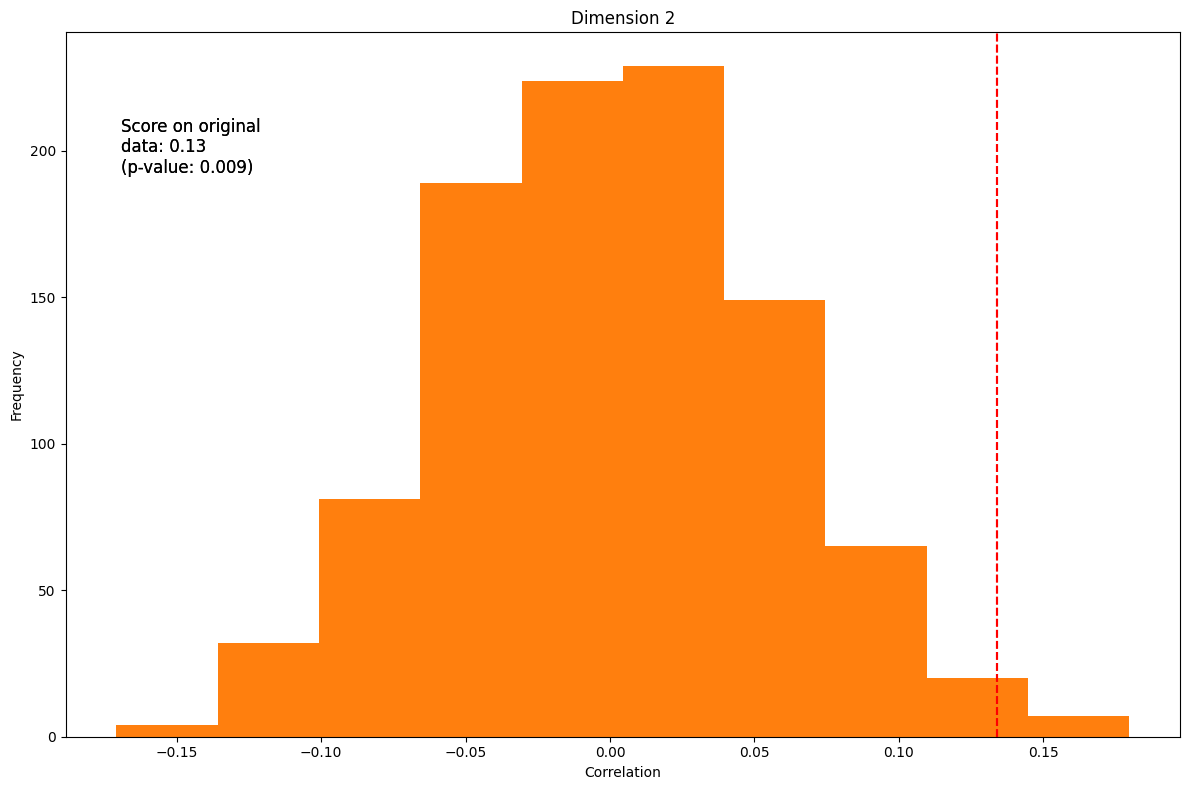

In [25]:
fig, ax = plt.subplots(1, figsize=[12, 8])
for k in range(2):
    ax.hist(perm_scores)
    ax.axvline(score, ls="--", color="r")
    
    score_label = f"Score on original\ndata: {score:.2f}\n(p-value: {p_values:.3f})"
    ax.text(0.05, 0.8, score_label, fontsize=12, transform=ax.transAxes)
    ax.set_xlabel("Correlation")
    _ = ax.set_ylabel("Frequency")
    ax.set_title(f"Dimension {k + 1}")
plt.tight_layout()
plt.show()


In [ ]:
"""from sklearn.utils import shuffle

num_permutations = 1000
null_distributions = []

U, V = best_model.transform((X, Y))

canonical_corr = np.corrcoef(U[:, 0], Y.T)[0, 1:]

original_corr = np.corrcoef(U[:, 0], Y.T)[0, 1:]

for _ in range(num_permutations):
    # Shuffle Y values
    Y_permuted = shuffle(Y)
    model.fit((X, Y_permuted))
    U_perm, V_perm = model.transform((X, Y_permuted))
    perm_corr = np.corrcoef(U_perm[:, 0], Y_permuted.T)[0, 1:]
    null_distributions.append(perm_corr)

null_distributions = np.array(null_distributions)
p_values = np.mean(null_distributions >= original_corr, axis=0)"""

# Determine significant correlations (e.g., p < 0.05)
significant_indices = np.where(p_values < 0.05)[0]
significant_questions = clinical_features.columns[top_indices]

significant_correlations = original_corr[significant_indices]
significant_p_values = p_values[significant_indices]

# Create a DataFrame to display the results
significant_results = pd.DataFrame({
    'Clinical Question': significant_questions,
    'Correlation': significant_correlations,
    'p-value': significant_p_values
}).sort_values(by='Correlation', ascending=False)

# Display the results using ace_tools


# Plot the null distribution and original correlation for visualization
plt.hist(null_distributions.flatten(), bins=50, alpha=0.7, label='Null Distribution')
plt.axvline(np.max(original_corr), color='red', linestyle='dashed', linewidth=2, label='Original Correlation')
plt.legend()
plt.title('Null Distribution of Canonical Correlations')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.show()

significant_results

In [ ]:
p_values

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from cca_zoo.linear import SCCA_IPLS
from cca_zoo.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Example data
# Replace this with your actual data
#X = np.random.rand(100, 10)  # Language features
#Y = np.random.rand(100, 5)   # Clinical features

X = language_features.values
Y = clinical_features.values

# Define 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
outer_correlations = []

# Outer cross-validation loop
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    # Check if there are enough samples for inner 3-fold cross-validation
    if len(X_train) < 3:
        raise ValueError(f"Not enough samples for 3-fold cross-validation. Only {len(X_train)} samples available.")

    # Inner 3-fold cross-validation for hyperparameter tuning
    inner_kf = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Define the model with hyperparameter grid search
    model = SCCA_IPLS()

    param_grid = {
        'alpha': [0.1, 0.5, 1.0],  # regularization parameter
        'l1_ratio': [0.1, 0.5, 0.9]  # L1/L2 ratio
    }

    def cca_score(model, X, Y):
        model.fit((X, Y))
        return np.mean(model.score((X, Y)))

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_kf)
    grid_search.fit((X_train, Y_train))

    best_model = grid_search.best_estimator_

    # Train the model on the entire training set with the best hyperparameters
    best_model.fit((X_train, Y_train))

    # Calculate canonical correlations on the test set
    correlation = best_model.score((X_test, Y_test))
    outer_correlations.append(correlation)

    # Permutation test to assess significance
    n_permutations = 50
    permuted_correlations = []

    for i in range(n_permutations):
        Y_train_permuted = np.random.permutation(Y_train)
        model.fit((X_train, Y_train_permuted))
        permuted_correlations.append(model.score((X_test, Y_test)))

    p_value = (np.sum(permuted_correlations >= correlation) + 1) / (n_permutations + 1)
    print(f"Canonical Correlation: {correlation}, p-value: {p_value}")

# Results
print(f"Mean Canonical Correlation: {np.mean(outer_correlations)}")
